Changes - 90% train size, 5% test size, 5% val size

# 1. Install Dependencies and Setup

In [1]:
! pip install standard-imghdr

In [2]:
!pip install opencv-python matplotlib

In [3]:
!pip list

Package                  Version
------------------------ -----------
absl-py                  2.1.0
asttokens                3.0.0
astunparse               1.6.3
certifi                  2024.12.14
charset-normalizer       3.4.0
comm                     0.2.2
contourpy                1.3.1
cycler                   0.12.1
debugpy                  1.8.11
decorator                5.1.1
executing                2.1.0
flatbuffers              24.3.25
fonttools                4.55.3
gast                     0.6.0
google-pasta             0.2.0
grpcio                   1.68.1
h5py                     3.12.1
idna                     3.10
ipykernel                6.29.5
ipython                  8.30.0
jedi                     0.19.2
jupyter_client           8.6.3
jupyter_core             5.7.2
keras                    3.7.0
kiwisolver               1.4.7
libclang                 18.1.1
Markdown                 3.7
markdown-it-py           3.0.0
MarkupSafe               3.0.2
matplotlib        

In [4]:
import tensorflow as tf
import os
print("TensorFlow version:", tf.__version__)

2024-12-19 10:50:46.039172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 10:50:46.183236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734605446.233107   38110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734605446.247509   38110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 10:50:46.368703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0


In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

/tmp/ipykernel_38110/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4998 files belonging to 2 classes.


I0000 00:00:1734605459.356184   38110 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
# Class 0 = Healthy
# Class 1 = Tumor
batch[1]

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

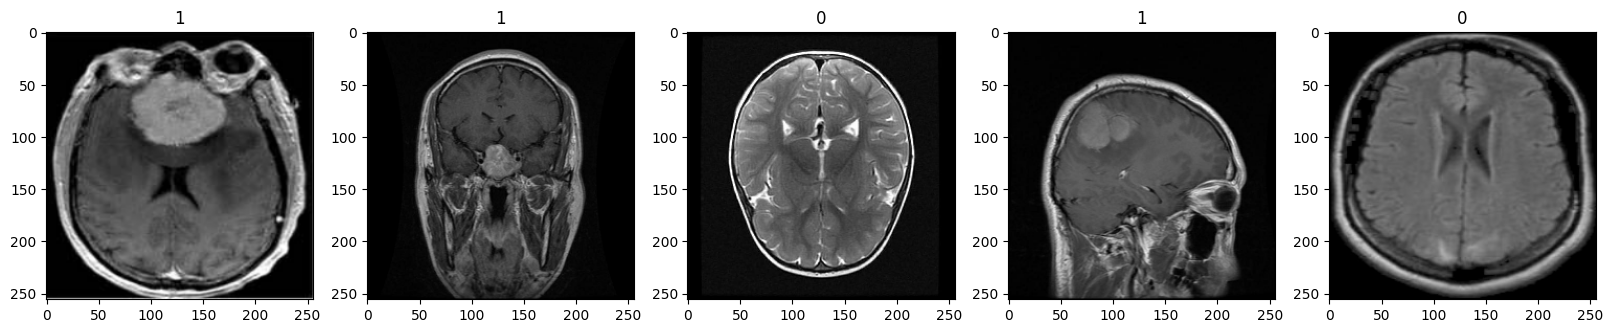

In [16]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
batch[0].min()

np.float32(0.0)

# 4. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
scaled_iterator = data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

In [21]:
batch[0].max()

np.float32(1.0)

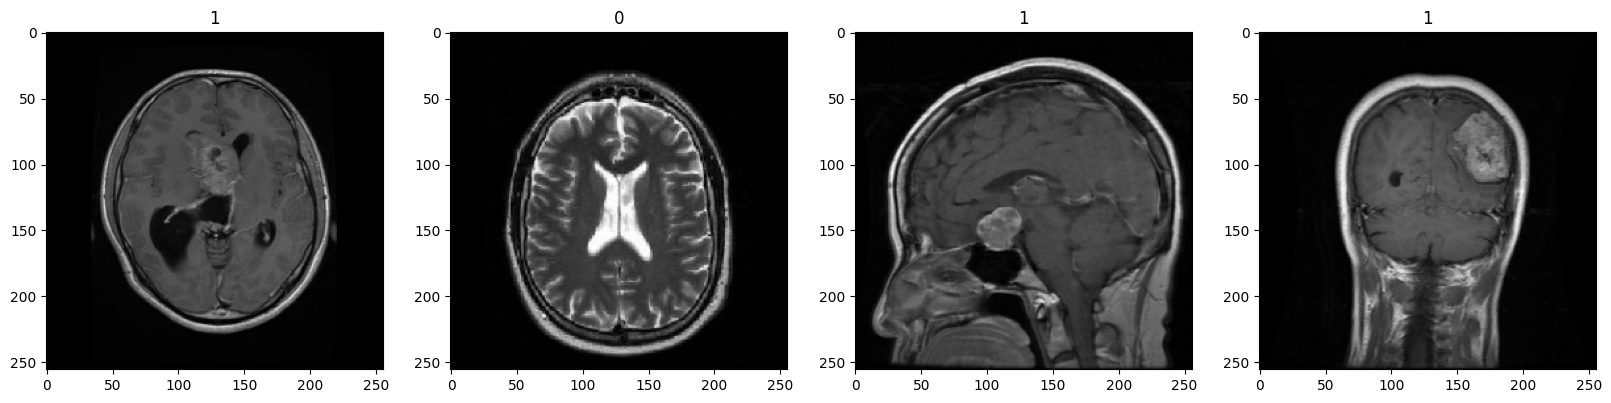

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [23]:
len(data)

157

In [25]:
train_size = int(len(data)*.9)+1
val_size = int(len(data)* 0.05) +1
test_size = int(len(data)* 0.05)

In [32]:
print(f"TRAIN SIZE: {train_size} \nVAL SIZE: {val_size} \nTEST SIZE: {test_size}")
print(f"SUM: {train_size+test_size+val_size}")

TRAIN SIZE: 142 
VAL SIZE: 8 
TEST SIZE: 7
SUM: 157


In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [35]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
import keras
from keras import layers

In [37]:
print(keras.__version__)

3.7.0


In [38]:
model = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [39]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1734605742.483774   38269 service.cc:148] XLA service 0x7f6f6820a140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734605742.484836   38269 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-19 10:55:42.604927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734605743.019422   38269 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-19 10:55:46.820532: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[32,32,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,127,127]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNon

  4/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5710 - loss: 0.9546 

I0000 00:00:1734605749.087392   38269 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7105 - loss: 0.5734 - val_accuracy: 0.8789 - val_loss: 0.2777
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9165 - loss: 0.2256 - val_accuracy: 0.9688 - val_loss: 0.0910
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9638 - loss: 0.1072 - val_accuracy: 0.9727 - val_loss: 0.0843
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9788 - loss: 0.0627 - val_accuracy: 0.9648 - val_loss: 0.0830
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9901 - loss: 0.0283 - val_accuracy: 0.9922 - val_loss: 0.0443
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9986 - loss: 0.0122 - val_accuracy: 0.9922 - val_loss: 0.0201
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9944 - loss: 0.0147 - val_accuracy: 0.9922 - val_loss: 0.0213
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9984 - loss: 0.0070 - val_accuracy: 0.98

# 8. Plot Performance

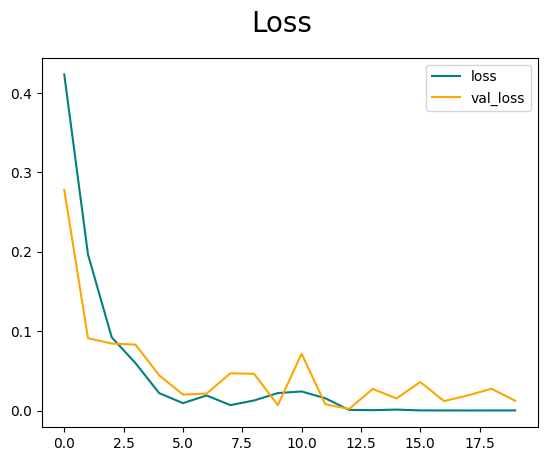

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

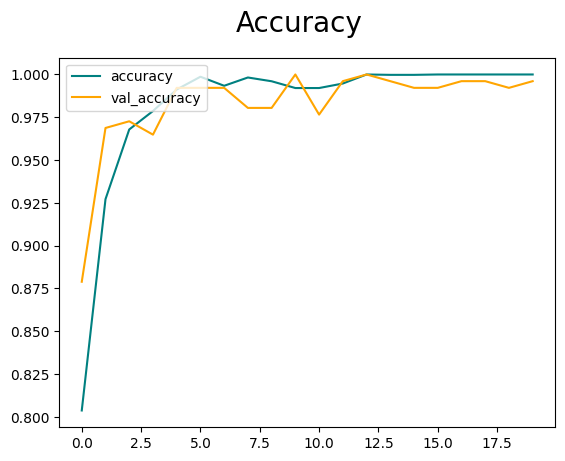

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


2024-12-19 10:57:43.224006: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [50]:
print(f"Precision: {pre.result().numpy():.3f}, \nRecall: {re.result().numpy():.3f}, \nAccuracy: {acc.result().numpy():.3f}")

Precision: 0.992, 
Recall: 1.000, 
Accuracy: 0.995


# 10. Test

In [51]:
import cv2

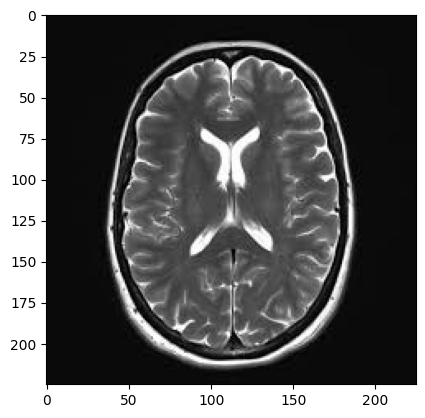

In [61]:
img = cv2.imread('mri_healthy (1997).jpg')
plt.imshow(img)
plt.show()

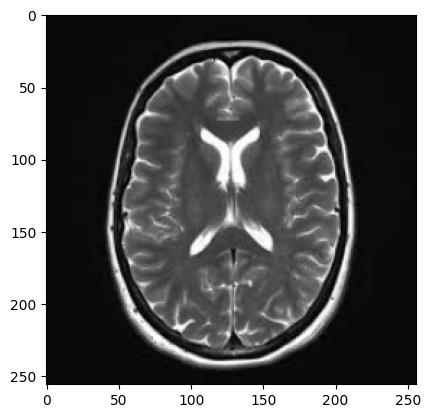

In [62]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [63]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [64]:
yhat

array([[1.4712265e-16]], dtype=float32)

In [65]:
if yhat > 0.5: 
    print(f'Predicted class = Tumor')
else:
    print(f'Predicted class = Healthy')

Predicted class = Healthy


# 11. Save the Model

In [57]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','02_ImageClassifierBrainTumor_Model.keras'))

In [59]:
new_model = load_model(os.path.join('models','02_ImageClassifierBrainTumor_Model.keras'))

In [60]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


array([[1.]], dtype=float32)